In [2]:
import numpy as np
import pandas as pd
import re
import scipy.stats as st
import sklearn.metrics as met
import matplotlib.pyplot as plt
import sklearn.preprocessing as prep
import time
import copy

%matplotlib inline
title = 'PPD'
path = '../sources/data/PPD-First-Round-Data'
icy = 'target'

# def Del_string(xstr):
#     xstrc = xstr.strip().strip(u'市').strip(u'省')
#     if(xstrc == ''):
#         xstrc = np.nan
#     return(xstrc)

## Reload DataSet for Model

In [3]:
pathofDataSaving = '../sources/deal/PPD-Data-Saving'
irt = np.load('{}/{}_irt.npy'.format(pathofDataSaving, title))
irv = np.load('{}/{}_irv.npy'.format(pathofDataSaving, title))
dac = pd.read_hdf('{}/{}_dac.h5'.format(pathofDataSaving, title), key = 'dac')
print dac.shape
print dac.loc[irt, icy].value_counts()/dac.loc[irt, icy].shape[0]

(49999, 389)
0.0    0.926733
1.0    0.073267
Name: target, dtype: float64


In [38]:
# dac.loc[:, [icy]]
# dac.loc[:, icy]

## DataSet Division, Missing Deal & Standardization

xt -  
yt -  
xv -  

In [4]:
y = dac.loc[:, [icy]]
icx = list(set(dac.columns) - set([icy]))
x = dac.loc[:, icx]
x = x.apply(lambda x: x.fillna(x.median()),axis=0) # 使用中位数填充缺失值
x = (x.rank(pct = True)-0.5/x.shape[0]).apply(st.norm.ppf) # 正态标准化
#x = (x - x.mean())/x.std() # 中心归一标准化
xt = x.loc[irt, :].values
yt = y.loc[irt, :].values
xv = x.loc[irv, :].values

In [5]:
# TrainSet
# 特别需要注意yt的shape
print xt.shape
print yt.shape
print yt.flatten().shape
# https://stackoverflow.com/questions/35022463/stratifiedkfold-indexerror-too-many-indices-for-array
# Check the shape of skew_gendata_targets.values. You'll see that it isn't a 1d array (shape (500,) ) as StratifiedKFold expects, but rather a (500,1) array. SKlearn treats these separately rather than coercing them to be the same. Let me know if that helps

(30000, 388)
(30000, 1)
(30000,)


## Definition of Models

Different model types for training from sub training and validation sets, random seed and model parameters

Input:
* xt1, yt1: sub training sets for data
* xt2, yt2: sub validation sets for data
* seed: random seed for the model
* parmodel: parameters of the model

Processing:
1. Train the model
1. Print validation score and running time

Output:
* model: trained machine learning model

#### Model Type: Scikit-learn Classifiers
Support of modeltype:
* lm: LogisticRegression, SGDClassifier
* ensm: AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier

In [6]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
import sklearn.ensemble as ensm
def Classifier(xt1, xt2, yt1, yt2, seed = 0, modeltype = LogisticRegression, parmodel = {}):
    timestart = time.time()
    par = {"random_state": seed, 'n_jobs': -1, "penalty": "l2", "C": 0.003, "class_weight": 'balanced', 'solver': 'sag'}
    par.update(parmodel)
    model = modeltype(**par)
    model.fit(xt1, yt1.flatten())
#     score = Score(yt2, model.predict_proba(xt2)[:,1:])
    print('Time: {:.2f} seconds'.format(time.time() - timestart))
    return(model)

#### Model Type: XGBoost

In [7]:
import xgboost as xgb
def XGBoost(xt1, xt2, yt1, yt2, seed = 0, parmodel = {}):
    timestart = time.time()
    xyt1 = xgb.DMatrix(xt1, label = yt1, missing = np.nan)
    xyt2 = xgb.DMatrix(xt2, label = yt2, missing = np.nan)
    par = {'colsample_bylevel': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'sub_sample': 1, 
           'eta': 0.1, "seed": seed, "objective": 'binary:logistic', 'eval_metric': 'logloss'}
    par.update(parmodel)
    par['max_depth'] = int(par['max_depth'])
    parval = [(xyt1,'train'), (xyt2,'val')]
    model = xgb.train(params = par, dtrain = xyt1, num_boost_round = 10000, evals = parval, 
                      early_stopping_rounds = int(2*np.sqrt(xt1.shape[1]/par['eta'])))
    score = Score(yt2, ModelPredict(xt2, model))
    print('Time: {:.2f} seconds'.format(time.time() - timestart))
    return(model)

/Users/fanghan/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Model Type: Neural Network

In [8]:
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.regularizers import activity_l2
from keras.constraints import maxnorm
def DNN(xt1, xt2, yt1, yt2, seed = 0, parmodel = {}):
    np.random.seed(seed)
    timestart = time.time()
    par = {"nhidlayer": 2, "rdrop": 0.5, "nhidnode": 500, "outnode": 300,
           'optimizer':'sgd', "batch_size": 64, "earlystop": 3, "maxnorm": 4, "l2": 0}
    par.update(parmodel)
    layerin = Input(shape=(xt1.shape[1],))
    layer = layerin
    for i in range(par["nhidlayer"]):
        layer = Dense(par["nhidnode"], init = 'glorot_normal', activation="relu", W_constraint = maxnorm(par["maxnorm"]))(layer)
        layer = BatchNormalization()(layer)
        layer = Dropout(par["rdrop"])(layer)
    layer = Dense(par["outnode"], init = 'glorot_normal', activation="relu", W_constraint = maxnorm(par["maxnorm"]))(layer)
    layer = BatchNormalization()(layer)
    layer = Dropout(par["rdrop"])(layer)
    layerout = Dense(1, activation='sigmoid')(layer)
    model = Model(input=layerin, output=layerout)
    model.compile(loss='binary_crossentropy', optimizer=par['optimizer'])
    model.fit(xt1.astype("float32"), yt1.astype("float32"), nb_epoch=100, batch_size=par["batch_size"], validation_data = (xt2, yt2), 
              callbacks = [EarlyStopping(monitor='val_loss', patience=par["earlystop"])])
    score = Score(yt2, ModelPredict(xt2, model))
    print("Time: {:.2f} seconds".format(time.time() - timestart))
    return(model)

ImportError: No module named keras.layers

## Cross Validation Func

Divide sub training and validation sets by **StratifiedKFold**

In [8]:
from sklearn.model_selection import StratifiedKFold

## Training Methods Definition with CV

Functions for models to train, validate and predict Y from data

### Model Training with CV

参考源码 model_selection.cross_val_score()

In [45]:
# rewrite kfolds
# 备注：带交叉验证的training ： crosstrain func() # output： 保存StratifiedKFold切分index & 全部model & 全部score备用
def CrossTrain_new(x, y, fmodel, k=10, **kwargs):
    modelL = []
    irtL_T = []
    irtL_V = [] 
    skf = StratifiedKFold(n_splits=k, random_state=0, shuffle=True)
    for train_index, valid_index in skf.split(x, y.flatten()):
        irtL_T.append(train_index)
        irtL_V.append(valid_index)
        X_train, X_valid = x[train_index], x[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        print pd.Series(y_train.flatten()).value_counts() / y_train.shape[0]
        print pd.Series(y_valid.flatten()).value_counts() / y_valid.shape[0]
        modelL.append(fmodel(X_train, X_valid, y_train, y_valid, seed = 0, **kwargs))
        print '\n'
    return modelL, irtL_T, irtL_V

### Model Validation with CV

In [33]:
def ModelPredict(xv, fmodel):
    if(type(fmodel) == xgb.core.Booster):
        xv = xgb.DMatrix(xv, missing = np.nan)
    if(type(fmodel) in [LogisticRegression, SGDClassifier, ensm.bagging.BaggingClassifier,
           ensm.weight_boosting.AdaBoostClassifier, ensm.forest.RandomForestClassifier, ensm.forest.ExtraTreesClassifier]):
        yvp = fmodel.predict_proba(xv)[:,1]
    else:
        yvp = fmodel.predict(xv).flatten()
    return(yvp)

def CrossValid_new(x, y, irtL_T, irtL_V, modelL):
    yt2pL = []
    for i in range(len(modelL)):
        xt1, xt2, yt1, yt2 = xt[irtL_T[i]], xt[irtL_V[i]], yt[irtL_T[i]], yt[irtL_V[i]]
        yt2p = ModelPredict(xt2, modelL[i])
        yt2pL.append(yt2p)
    return yt2pL

### Model Score Evaluation with CV

In [34]:
def Score(y, yp, f = met.roc_auc_score):
    score = f(y, yp)
    print("Score: {:.4f}".format(score))
    return(score)

def CrossScore_new(yt, yvpM, irtL_V, w = 1):
    score = []
    for i in range(len(irtL_V)):
        yt2 = yt[irtL_V[i]]
        yvpLw = [yvpM[j][i] for j in range(len(yvpM))]
        if (w is 1):
            score.append(list(map(lambda x: Score(yt2, x), yvpLw)))
        else:
            score.append(Score(yt2, np.array(yvpLw).T * w))
    print 'ValidSet Score with %d-folds: %.4f +/- %.4f'%(len(irtL_V), np.mean(score, axis=0), np.std(score, axis=0))
    return np.array(score)

# CrossScoreAnalysis(y, [yt2pL], irtL)[0]

In [12]:
def ScoreWeight(score):
    w = np.exp((score - np.mean(score))/np.min(np.std(score, axis = 0)))
    w = np.sum(w/np.sum(w), axis = 0)
    return(w)

def CrossScoreAnalysis(y, yvpM, irtL_V, w = [], labels = None):
    scoreL = CrossScore_new(y, yvpM, irtL_V)
    if(len(w) == 0):
        w = ScoreWeight(scoreL)
        print w
    score = CrossScore_new(y, yvpM, irtL_V, w)
    # ScorePlot(np.vstack([score, scoreL.T]).T, labels)
    return(scoreL, score, np.array(w))

## Model Pre-Training
Training for model selection and preestimate of hyper-parameters
### Single Models
Train a single model from a single pair of sub training and validation sets

#### LR with default parameters

In [14]:
par = {'penalty': 'l2', 'C': 0.003, 'class_weight': 'balanced', 'solver': 'sag'}
modelL, irtL_T, irtL_V = CrossTrain_new(xt, yt, fmodel=Classifier, parmodel = par)
yvpL = CrossValid_new(xt, yt, irtL_T, irtL_V, modelL)
scoreL = CrossScore_new(yt, [yvpL], irtL_V)

0.0    0.926738
1.0    0.073262
dtype: float64
0.0    0.926691
1.0    0.073309
dtype: float64
Time: 3.78 seconds


0.0    0.926738
1.0    0.073262
dtype: float64
0.0    0.926691
1.0    0.073309
dtype: float64
Time: 4.18 seconds


0.0    0.926741
1.0    0.073259
dtype: float64
0.0    0.926667
1.0    0.073333
dtype: float64
Time: 4.22 seconds


0.0    0.926741
1.0    0.073259
dtype: float64
0.0    0.926667
1.0    0.073333
dtype: float64
Time: 3.18 seconds


0.0    0.926741
1.0    0.073259
dtype: float64
0.0    0.926667
1.0    0.073333
dtype: float64
Time: 3.04 seconds


0.0    0.926741
1.0    0.073259
dtype: float64
0.0    0.926667
1.0    0.073333
dtype: float64
Time: 3.24 seconds


0.0    0.926741
1.0    0.073259
dtype: float64
0.0    0.926667
1.0    0.073333
dtype: float64
Time: 3.26 seconds


0.0    0.926741
1.0    0.073259
dtype: float64
0.0    0.926667
1.0    0.073333
dtype: float64
Time: 3.04 seconds


0.0    0.926706
1.0    0.073294
dtype: float64
0.0    0.926976
1.0    0.073024
d

In [16]:
np.mean(CrossScoreAnalysis(yt, [yvpL], irtL_V)[0]), np.std(CrossScoreAnalysis(yt, [yvpL], irtL_V)[0])

Score: 0.7349
Score: 0.7503
Score: 0.7492
Score: 0.7516
Score: 0.7506
Score: 0.7584
Score: 0.7861
Score: 0.7331
Score: 0.7388
Score: 0.7983
ValidSet Score with 10-folds: 0.7551 +/- 0.0202
[ 1.]
Score: 0.7349
Score: 0.7503
Score: 0.7492
Score: 0.7516
Score: 0.7506
Score: 0.7584
Score: 0.7861
Score: 0.7331
Score: 0.7388
Score: 0.7983
ValidSet Score with 10-folds: 0.7551 +/- 0.0202
Score: 0.7349
Score: 0.7503
Score: 0.7492
Score: 0.7516
Score: 0.7506
Score: 0.7584
Score: 0.7861
Score: 0.7331
Score: 0.7388
Score: 0.7983
ValidSet Score with 10-folds: 0.7551 +/- 0.0202
[ 1.]
Score: 0.7349
Score: 0.7503
Score: 0.7492
Score: 0.7516
Score: 0.7506
Score: 0.7584
Score: 0.7861
Score: 0.7331
Score: 0.7388
Score: 0.7983
ValidSet Score with 10-folds: 0.7551 +/- 0.0202


(0.75513397190858633, 0.020217423421932779)

### LR for hyperopt

In [17]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import hyperopt.pyll.stochastic

In [18]:
space = {'C': hp.loguniform('C', -10, -1)}
print np.exp(-10), '--', np.exp(-1)
# print(hyperopt.pyll.stochastic.sample(space))
# print(hyperopt.pyll.stochastic.sample(space))
# print(hyperopt.pyll.stochastic.sample(space))
# print(hyperopt.pyll.stochastic.sample(space))
# print(hyperopt.pyll.stochastic.sample(space))

4.53999297625e-05 -- 0.367879441171


In [43]:
# 5-folds
# CrossTrain five models
# 就是说我把含有默认值的参数放在了不含默认值的参数的前面，这样问题就好解决了，调换一下参数的位置就好了
def ParModelScore(par, fmodel = Classifier):
    modelL, irtL_T, irtL_V = CrossTrain_new(xt, yt, fmodel, k = 5, parmodel = par)
    yvpL = CrossValid_new(xt, yt, irtL_T, irtL_V, modelL)
    score = np.mean(CrossScore_new(yt, [yvpL], irtL_V)[0])
    return (-score)

def HpOpt(space, fhpscore, seed = 0, max_evals = 50):
    def Obj(par):
        print(pd.DataFrame(par, index = [seed]))
        return({
            'loss': fhpscore(par),
            'status': STATUS_OK,
            'loss_variance': 5e-5
        })
    
    np.random.seed(seed)
    trials = Trials()
    best = fmin(Obj,
        space=space,
        algo=tpe.suggest,
        max_evals=max_evals,
        trials=trials)
    op = pd.concat([pd.DataFrame([sum(list(trials.trials[i]["misc"]["vals"].values()), []) for i in range(len(trials))],
                                 columns = list(trials.trials[0]["misc"]["vals"].keys())),
           pd.DataFrame({'loss': trials.losses()})], axis = 1)
    return(op)

In [44]:
space = {'C': hp.loguniform("C", -10, -2)}
parda = HpOpt(space, lambda x:ParModelScore(x, fmodel = Classifier), max_evals = 30).sort_values(['loss'])

          C
0  0.000207
0.0    0.926747
1.0    0.073253
dtype: float64
0.0    0.926679
1.0    0.073321
dtype: float64
Time: 1.81 seconds


0.0    0.926747
1.0    0.073253
dtype: float64
0.0    0.926679
1.0    0.073321
dtype: float64
Time: 1.70 seconds


0.0    0.92675
1.0    0.07325
dtype: float64
0.0    0.926667
1.0    0.073333
dtype: float64
Time: 1.48 seconds


0.0    0.926711
1.0    0.073289
dtype: float64
0.0    0.926821
1.0    0.073179
dtype: float64
Time: 1.58 seconds


0.0    0.926711
1.0    0.073289
dtype: float64
0.0    0.926821
1.0    0.073179
dtype: float64
Time: 1.58 seconds


Score: 0.7285
Score: 0.7364
Score: 0.7240
Score: 0.7565
Score: 0.7609
ValidSet Score with 5-folds: 0.7412 +/- 0.0148
          C
0  0.000085
0.0    0.926747
1.0    0.073253
dtype: float64
0.0    0.926679
1.0    0.073321
dtype: float64
Time: 1.61 seconds


0.0    0.926747
1.0    0.073253
dtype: float64
0.0    0.926679
1.0    0.073321
dtype: float64
Time: 1.41 seconds


0.0    0.92675
1.0    0.07325
dt

In [46]:
# parda
paropt = parda.iloc[0, :-1].to_dict()
paropt

{'C': 0.0032894633897414399}

In [47]:
# 根据hyperopt的最优参数重新训练模型并对结果做预测
par = {'penalty': 'l2', 'class_weight': 'balanced', 'solver': 'sag'}
par.update(paropt)
modelLRL, irtL_T, irtL_V = CrossTrain_new(xt, yt, fmodel=Classifier, parmodel = par)
yvpL = CrossValid_new(xt, yt, irtL_T, irtL_V, modelLRL)
scoreL = CrossScore_new(yt, [yvpL], irtL_V)
# crosspredict
# 备注： 我们掌握了初赛轮具体结果，因此可以直接模拟线上得分

0.0    0.926738
1.0    0.073262
dtype: float64
0.0    0.926691
1.0    0.073309
dtype: float64
Time: 3.67 seconds


0.0    0.926738
1.0    0.073262
dtype: float64
0.0    0.926691
1.0    0.073309
dtype: float64
Time: 3.46 seconds


0.0    0.926741
1.0    0.073259
dtype: float64
0.0    0.926667
1.0    0.073333
dtype: float64
Time: 3.37 seconds


0.0    0.926741
1.0    0.073259
dtype: float64
0.0    0.926667
1.0    0.073333
dtype: float64
Time: 5.14 seconds


0.0    0.926741
1.0    0.073259
dtype: float64
0.0    0.926667
1.0    0.073333
dtype: float64
Time: 3.26 seconds


0.0    0.926741
1.0    0.073259
dtype: float64
0.0    0.926667
1.0    0.073333
dtype: float64
Time: 3.70 seconds


0.0    0.926741
1.0    0.073259
dtype: float64
0.0    0.926667
1.0    0.073333
dtype: float64
Time: 4.69 seconds


0.0    0.926741
1.0    0.073259
dtype: float64
0.0    0.926667
1.0    0.073333
dtype: float64
Time: 4.34 seconds


0.0    0.926706
1.0    0.073294
dtype: float64
0.0    0.926976
1.0    0.073024
d

In [177]:
# 实际上与crossvalid函数一样
def CrossPredict(xv, modelL):
    yvpL = []
    for i in range(len(modelL)):
        yvp = ModelPredict(xv, modelL[i])
        yvpL.append(yvp)
    return(yvpL)

# 支持多模型w
def ModelMPredict(yvpM, w = 1):
    yvpcomp = np.array([np.mean(yvpM[i], axis = 0) for i in range(len(yvpM))]).T.dot(w).flatten()
    return(yvpcomp)

In [178]:
yvpLRL = CrossPredict(xv, modelLRL)
yvpLRL_df = pd.concat(map(lambda i: pd.DataFrame(yvpLRL[i], columns=[str(i)]), np.arange(len(yvpLRL))), axis=1)
yvpLRL_df.head()

# output
# ModelMPredict([yvpLRL])
op = pd.DataFrame({'score':ModelMPredict([yvpLRL])}, index = irv).reset_index().rename_axis({'index': 'Idx'}, axis = 1).set_index('Idx')

In [179]:
# 从第二轮数据中模拟初赛线上打分
newpath = './PPD-Second-Round-Data/first_round_test_data'
par_csv = dict(index_col = 0, encoding = 'GB18030', parse_dates = ["ListingInfo"], na_values = [-1], 
               converters = dict(zip(*[["UserInfo_{}".format(i) for i in [2,4,7,8,9,19,20]], [Del_string]*7])))

dat_fr1_master = pd.read_csv('{}/Kesci_Master_9w_gbk_2.csv'.format(newpath), **par_csv)

In [180]:
print op['score'].shape
print dat_fr1_master['target'].shape
print met.roc_auc_score(dat_fr1_master['target'], op['score'])

(19999,)
(19999,)
0.77084207963


## XGBoost

In [50]:
def Kfolds(x, k = 10, seed = 1):
    np.random.seed(seed)
    xL = np.array_split(np.random.choice(x, len(x), replace = False), k) #  相当于shuffle
    return(xL)

def GroupSelect(xL, i = 0):
    # xLc = xL.copy()
    # 改写
    xLc = copy.copy(xL)
    ingrp = list(xLc.pop(i))
    exgrp = sum([list(x) for x in xLc], [])
    return(ingrp, exgrp)

def TrainSet(x, y, irtL, ig = 0):
    irt2, irt1 = GroupSelect(irtL, i = ig)
    xt1, xt2 = x.loc[irt1].values, x.loc[irt2].values
    yt1, yt2 = y.loc[irt1].values, y.loc[irt2].values
    return(xt1, xt2, yt1, yt2)

In [53]:
# irtL = Kfolds(irt, k = 10)
# xt1, xt2, yt1, yt2 = TrainSet(x, y, irtL, ig = 0)
# model = XGBoost(xt1, xt2, yt1, yt2, seed = 0, parmodel = 
#                 {'colsample_bylevel': 0.07, 'eta': 0.05, 'max_depth': 3, 'lambda': 50, 'min_child_weight': 1.5, 'gamma': 0.2})

In [54]:
modelXGBL = []
for i in range(10):
    xt1, xt2, yt1, yt2 = TrainSet(x, y, irtL, ig = i)
#     print calcBalanceRate(pd.DataFrame(yt1.flatten(), columns=['target']))
#     print calcBalanceRate(pd.DataFrame(yt2.flatten(), columns=['target']))
    modelXGBL.append(XGBoost(xt1, xt2, yt1, yt2, seed = 0, parmodel = 
                {'colsample_bylevel': 0.07, 'eta': 0.05, 'max_depth': 3, 'lambda': 50, 'min_child_weight': 1.5, 'gamma': 0.2}))
    print '\n'

[0]	train-logloss:0.657923	val-logloss:0.657672
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 176 rounds.
[1]	train-logloss:0.626063	val-logloss:0.625579
[2]	train-logloss:0.597122	val-logloss:0.596422
[3]	train-logloss:0.570776	val-logloss:0.569871
[4]	train-logloss:0.546726	val-logloss:0.545617
[5]	train-logloss:0.524673	val-logloss:0.523339
[6]	train-logloss:0.50444	val-logloss:0.502937
[7]	train-logloss:0.485866	val-logloss:0.48421
[8]	train-logloss:0.468786	val-logloss:0.466976
[9]	train-logloss:0.453059	val-logloss:0.451056
[10]	train-logloss:0.438569	val-logloss:0.436389
[11]	train-logloss:0.425118	val-logloss:0.422784
[12]	train-logloss:0.412707	val-logloss:0.410198
[13]	train-logloss:0.401275	val-logloss:0.398609
[14]	train-logloss:0.390659	val-logloss:0.387895
[15]	train-logloss:0.380834	val-logloss:0.377876
[16]	train-logloss:0.37169	val-logloss:0.368613
[17]	train-logloss:0.363177	val-

In [56]:
modelXGBL_bak = modelXGBL[:]
modelXGBL = []

#### XGBoost Training with Stratified 10-Folds

In [46]:
par = {'colsample_bylevel': 0.07, 'eta': 0.05, 'max_depth': 3, 'lambda': 50, 'min_child_weight': 1.5, 'gamma': 0.2}
modelXGBL, irtL_T, irtL_V = CrossTrain_new(xt, yt, fmodel=XGBoost, parmodel = par)

0.0    0.926738
1.0    0.073262
dtype: float64
0.0    0.926691
1.0    0.073309
dtype: float64
[0]	train-logloss:0.657891	val-logloss:0.657895
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 176 rounds.
[1]	train-logloss:0.625988	val-logloss:0.625995
[2]	train-logloss:0.597015	val-logloss:0.597033
[3]	train-logloss:0.570628	val-logloss:0.570661
[4]	train-logloss:0.546499	val-logloss:0.546566
[5]	train-logloss:0.524412	val-logloss:0.524498
[6]	train-logloss:0.504153	val-logloss:0.504233
[7]	train-logloss:0.485562	val-logloss:0.485665
[8]	train-logloss:0.468448	val-logloss:0.468621
[9]	train-logloss:0.452681	val-logloss:0.452857
[10]	train-logloss:0.438154	val-logloss:0.438344
[11]	train-logloss:0.424674	val-logloss:0.424893
[12]	train-logloss:0.412232	val-logloss:0.412469
[13]	train-logloss:0.40077	val-logloss:0.40102
[14]	train-logloss:0.390142	val-logloss:0.390452
[15]	train-logloss:0.380299	val-log

In [44]:
# no shuffle
res_noshuffle = []
for i in range(len(irtL_V)):
    res_noshuffle.extend(irtL_V[i])
# pd.Series(res_noshuffle)

In [48]:
res_shuffle = []
for i in range(len(irtL_V)):
    res_shuffle.extend(irtL_V[i])
pd.Series(res_shuffle)

0            9
1           22
2           26
3           35
4           41
5           53
6           82
7           95
8          113
9          134
10         142
11         165
12         168
13         169
14         185
15         186
16         189
17         201
18         217
19         232
20         243
21         257
22         266
23         278
24         279
25         288
26         303
27         305
28         307
29         314
         ...  
29970    29667
29971    29669
29972    29672
29973    29686
29974    29699
29975    29705
29976    29718
29977    29731
29978    29733
29979    29737
29980    29756
29981    29759
29982    29786
29983    29791
29984    29803
29985    29842
29986    29846
29987    29862
29988    29879
29989    29881
29990    29883
29991    29889
29992    29907
29993    29914
29994    29917
29995    29933
29996    29942
29997    29946
29998    29948
29999    29972
Length: 30000, dtype: int64

In [196]:
# XGBOOST predict method
# xgboost predict 直接输出概率值
i = 0
xt2, yt2 = xt[irtL_V[i]], yt[irtL_V[i]]
xt2 = xgb.DMatrix(xt2, missing=np.nan)
print modelL[i].predict(xt2)
# def ModelPredict(xv, fmodel):
#     if(type(fmodel) == xgb.core.Booster):
#         xv = xgb.DMatrix(xv, missing = np.nan)
#     if(type(fmodel) in [LogisticRegression, SGDClassifier, ensm.bagging.BaggingClassifier,
#            ensm.weight_boosting.AdaBoostClassifier, ensm.forest.RandomForestClassifier, ensm.forest.ExtraTreesClassifier]):
#         yvp = fmodel.predict_proba(xv)[:,1]
#     else:
#         yvp = fmodel.predict(xv).flatten()
#     return(yvp)

array([ 0.02559856,  0.22333069,  0.1286467 , ...,  0.00939237,
        0.06018082,  0.14644797], dtype=float32)

In [49]:
yvpL = CrossValid_new(xt, yt, irtL_T, irtL_V, modelXGBL)
scoreL = CrossScore_new(yt, [yvpL], irtL_V)

# 0.6396 +/- 0.0781

Score: 0.7550
Score: 0.7828
Score: 0.7898
Score: 0.7873
Score: 0.7811
Score: 0.7559
Score: 0.7947
Score: 0.7403
Score: 0.7766
Score: 0.7539
ValidSet Score with 10-folds: 0.7717 +/- 0.0178


In [21]:
# model consistence

In [23]:
# newpath = './model_persistence/single_model'
from sklearn.externals import joblib
for i in range(len(modelXGBL)):
    joblib.dump(modelXGBL[i], './model_persistence/single_model/XGB_{}.pkl'.format(i))

### load

In [11]:
from sklearn.externals import joblib
modelXGBL = []
for i in range(10):
    modelXGBL.append(joblib.load('./model_persistence/single_model/XGB_{}.pkl'.format(i)))

In [22]:
# WEIGHTMODEL 函数调试
model = modelXGBL[0]
print type(model) == xgb.core.Booster
print pd.Series(model.get_fscore()).head()

True
f1      68
f10     46
f101     1
f102     9
f103    44
dtype: int64


In [27]:
# icx = list(set(dac.columns) - set([icy]))
# x = dac.loc[:, icx]
# icx 即TrainSet的col name list
print pd.Series(icx, index=['f{}'.format(x) for x in range(len(icx))]).head()

f0        Education_Info4_AR
f1    ThirdParty_Info_16_max
f2        UserInfo_19_内蒙古自治区
f3     Userupdate__hasbuycar
f4       SocialNetwork_count
dtype: object


In [39]:
wic = pd.concat([pd.Series(icx, index=['f{}'.format(x) for x in range(len(icx))]), pd.Series(model.get_fscore())], axis=1).set_index(0).sort_index().fillna(0)[1]
# print wic / np.sum(wic)
print wic.shape[0]

388


In [46]:
# debug for weightci line 1
# 置信区间（Confidence Interval）
# http://liusimin122.blog.sohu.com/149608382.html
# 1. 注意MAP函数的用法
w = pd.concat(map(WeightModel, modelXGBL), axis=1, keys=np.arange(len(modelXGBL)))
wb = pd.concat([w.mean(axis = 1), w.std(axis = 1)], axis = 1, keys = ["Mean", "Std"])
# 标准正态分布又称为u分布，是以0为均数、以1为标准差的正态分布，记为N（0，1）。
# 标准正态分布曲线下面积分布规律是：在-1.96～+1.96范围内曲线下的面积等于0.9500，在-2.58～+2.58范围内曲线下面积为0.9900。

# 知道样本均值(M)和标准差(ST)时：

#   置信区间下限：a=M - n*ST;     置信区间上限：a=M + n*ST; 

#   当求取90% 置信区间时 n=1.645  

#   当求取95% 置信区间时 n=1.96

#   当求取99% 置信区间时 n=2.576

Mean       Std
0                                         
Education_Info2_A       0.000000  0.000000
Education_Info2_AM      0.004388  0.013875
Education_Info2_AN      0.000000  0.000000
Education_Info2_AQ      0.000000  0.000000
Education_Info2_U       0.000000  0.000000
Education_Info3_毕业      0.271071  0.062882
Education_Info3_结业      0.000000  0.000000
Education_Info4_AE      0.000000  0.000000
Education_Info4_AR      0.000000  0.000000
Education_Info4_E       1.102302  0.250224
Education_Info4_F       0.000000  0.000000
Education_Info4_T       0.616022  0.365392
Education_Info4_V       0.000000  0.000000
Education_Info6_A       0.008707  0.018358
Education_Info6_AM      0.004320  0.013660
Education_Info6_AQ      0.000000  0.000000
Education_Info8_F       0.000000  0.000000
Education_Info8_Others  0.000000  0.000000
Education_Info8_T       0.082185  0.069873
Education_count         2.390426  0.314261
ListingInfo_Day         6.866126  0.914992
ListingInfo_DayofMonth  3.383476  0.423170
ListingInfo_DayofWeek   1.774590  0.219508
ListingInfo_DayofYear   3.893006  0.519786
ListingInfo_Year        0.331180  0.185140
Log_(-10, 13)           0.221494  0.048311
Log_(-4, 6)             1.742922  0.532806
Log_(1, 0)              0.821881  0.188139
Log_(1, 2)              0.261444  0.156438
Log_(1, 20)             0.111158  0.094176
...                          ...       ...
WeblogInfo_31           0.025725  0.029548
WeblogInfo_32           0.000000  0.000000
WeblogInfo_33           0.193121  0.093210
WeblogInfo_34           0.069512  0.051245
WeblogInfo_35           0.000000  0.000000
WeblogInfo_36           0.259172  0.167391
WeblogInfo_37           0.004320  0.013660
WeblogInfo_38           0.140084  0.098777
WeblogInfo_39           0.085969  0.062788
WeblogInfo_4            2.829470  0.502517
WeblogInfo_40           0.004941  0.015624
WeblogInfo_42           0.083276  0.074584
WeblogInfo_43           0.000000  0.000000
WeblogInfo_45           0.083417  0.096336
WeblogInfo_47           0.000000  0.000000
WeblogInfo_48           0.088690  0.082255
WeblogInfo_5            0.865061  0.210500
WeblogInfo_50           0.071347  0.062914
WeblogInfo_51           0.040867  0.050021
WeblogInfo_52           0.009286  0.019627
WeblogInfo_53           0.000000  0.000000
WeblogInfo_54           0.006965  0.022024
WeblogInfo_56           0.044887  0.027658
WeblogInfo_57           0.012481  0.027788
WeblogInfo_58           0.006965  0.022024
WeblogInfo_6            3.588052  0.535299
WeblogInfo_7            1.464448  0.395681
WeblogInfo_8            0.722992  0.255103
WeblogInfo_9            0.026879  0.037480
WeblogInfo_count        0.874701  0.356698

[388 rows x 2 columns]

In [41]:
# 分析评估特征重要性
def WeightModel(model):
    if(type(model) == LogisticRegression):
        wic = pd.DataFrame({"LR_beta": model.coef_[0]})
    elif(type(model) == xgb.core.Booster):
        wic = (pd.concat([pd.Series(icx, index = ['f{}'.format(x) for x in range(len(icx))]), pd.Series(model.get_fscore())], axis = 1)
            .set_index(0).sort_index().fillna(0)[1])
        wic = wic/np.sum(wic)*wic.shape[0]
    return(wic)

def WeightCI(fweight, modelL):
    w = pd.concat(map(fweight, modelL), axis = 1, keys = np.arange(len(modelL)))
    wb = pd.concat([w.mean(axis = 1), w.std(axis = 1)], axis = 1, keys = ['Mean', 'Std'])
    wb["LowerCI"] = wb["Mean"] - wb["Std"]*1.96/np.sqrt(len(modelL))
    wb["UpperCI"] = wb["Mean"] + wb["Std"]*1.96/np.sqrt(len(modelL))
    return(wb)


def RowS_summary(da, rows, f = ["sum", "count"]):
    grp = da.loc[rows.index].groupby(rows, axis = 0)
    daop = pd.concat(map(lambda x: getattr(grp, x)(), f), keys = f, axis = 1)
    return(daop)

def Col_group(ic, i = 0):
    cols = pd.Series([x.split('_')[i] for x in ic], index = ic)
    return(cols)

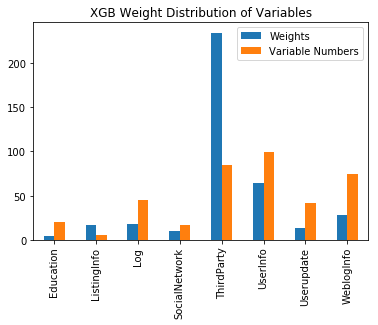

In [31]:
# WeightCI(WeightModel, modelXGBL)
wcolxgb = WeightCI(WeightModel, modelXGBL)
# wcolxgb.to_csv("{}/{}_w_xgb.csv".format(path, title))
RowS_summary(wcolxgb.iloc[:,0], Col_group(wcolxgb.index), ["sum", "count"]).rename(
    columns = {"sum": "Weights", "count": "Variable Numbers"}).plot(kind = "bar", title = "XGB Weight Distribution of Variables")

### xgboost for hyperopt

In [209]:
space = {'max_depth': hp.quniform("max_depth", 1.0, 5.0, 1),
         'min_child_weight': hp.loguniform("min_child_weight", -2, 4),
         'gamma': hp.loguniform("gamma", -6, 2),
         'lambda': hp.loguniform("lambda", 0, 6),
         'colsample_bylevel': hp.uniform('colsample_bylevel', 0.04, 0.15)
}
print(hyperopt.pyll.stochastic.sample(space))

{'gamma': 0.008457338540004933, 'colsample_bylevel': 0.11361085707406962, 'max_depth': 3.0, 'min_child_weight': 44.239900422930084, 'lambda': 9.779636612924643}


In [ ]:
# parda = HpOpt(space, ParModelScore(fmodel=XGBoost)).sort_values(["loss"])
# hpopt调用方法1:
parda = HpOpt(space, lambda x:ParModelScore(x, fmodel = XGBoost), max_evals = 30).sort_values(['loss'])
# parda.to_csv("{}/{}_par_xgb.csv".format(path, title))
# paropt = parda.iloc[0, :-1].to_dict()
# parda

   colsample_bylevel     gamma      lambda  max_depth  min_child_weight
0           0.069557  0.014498  244.916136        4.0         22.594927
0.0    0.926747
1.0    0.073253
dtype: float64
0.0    0.926679
1.0    0.073321
dtype: float64
[0]	train-logloss:0.626517	val-logloss:0.626529
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 124 rounds.
[1]	train-logloss:0.571686	val-logloss:0.571707
[2]	train-logloss:0.526029	val-logloss:0.52606
[3]	train-logloss:0.487673	val-logloss:0.487712
[4]	train-logloss:0.455232	val-logloss:0.455279
[5]	train-logloss:0.427652	val-logloss:0.427707
[6]	train-logloss:0.404113	val-logloss:0.404175
[7]	train-logloss:0.383962	val-logloss:0.384031
[8]	train-logloss:0.366671	val-logloss:0.366791
[9]	train-logloss:0.351708	val-logloss:0.35176
[10]	train-logloss:0.338906	val-logloss:0.338958
[11]	train-logloss:0.327766	val-logloss:0.327745
[12]	train-logloss:0.318156	val-loglos

In [ ]:
parda

In [77]:
def GroupSelect(xL, i = 0):
    # xLc = xL.copy()
    # 改写
    xLc = copy.copy(xL)
    ingrp = list(xLc.pop(i))
    exgrp = sum([list(x) for x in xLc], [])
    return(ingrp, exgrp)

def TrainSet(x, y, irtL, ig = 0):
    irt2, irt1 = GroupSelect(irtL, i = ig)
    xt1, xt2 = x.loc[irt1].values, x.loc[irt2].values
    yt1, yt2 = y.loc[irt1].values, y.loc[irt2].values
    return(xt1, xt2, yt1, yt2)

# crosstrain的实质就是用一个list把models存起来即可
def CrossTrain(x, y, irtL, fmodel, **kwargs):
    modelL = []
    for i in range(len(irtL)):
        xt1, xt2, yt1, yt2 = TrainSet(x, y, irtL, ig = i)
        modelL.append(fmodel(xt1, xt2, yt1, yt2, seed = i, **kwargs))
    return(modelL)

def CrossValid(x, y, irtL, modelL):
    yt2pL = []
    for i in range(len(irtL)):
        xt1, xt2, yt1, yt2 = TrainSet(x, y, irtL, ig = i)
        yt2p = ModelPredict(xt2, modelL[i])
        yt2pL.append(yt2p)
    return(yt2pL)

In [27]:
def Score(y, yp, f = met.roc_auc_score):
    score = f(y, yp)
    print("Score: {:.4f}".format(score))
    return(score)

def ModelPredict(xv, fmodel):
    if(type(fmodel) == xgb.core.Booster):
        xv = xgb.DMatrix(xv, missing = np.nan)
    if(type(fmodel) in [LogisticRegression, lm.stochastic_gradient.SGDClassifier, ensm.bagging.BaggingClassifier,
           ensm.weight_boosting.AdaBoostClassifier, ensm.forest.RandomForestClassifier, ensm.forest.ExtraTreesClassifier]):
        yvp = fmodel.predict_proba(xv)[:,1]
    else:
        yvp = fmodel.predict(xv).flatten()
    return(yvp)

### Model Variable Selection (functions)
Importance of variables for models in Y prediction from model training

In [14]:
def PlotWeight(w, score, hl = 0):
    fig = plt.figure()
    w.plot(kind = "bar", grid = True, title = "Score = {:.4}".format(score))
    plt.plot((0, w.shape[0]), (hl, hl), "k-")   
    fig.show()
def WeightModel(model):
    if(type(model) == lm.logistic.LogisticRegression):
        wic = pd.DataFrame({"LR_beta":model.coef_[0]}, index = x.columns)
    elif(type(model) == xgb.core.Booster):
        wic = (pd.concat([pd.Series(icx, index = ['f{}'.format(x) for x in range(len(icx))]), pd.Series(model.get_fscore())], axis = 1)
               .set_index(0).sort_index().fillna(0)[1])
        wic = wic/np.sum(wic)*wic.shape[0]
    return(wic)
def WeightCI(fweight, modelL):
    w = pd.concat(map(fweight, modelL), axis = 1, keys = np.arange(len(modelL)))
    wb = pd.concat([w.mean(axis = 1), w.std(axis = 1)], axis = 1, keys = ["Mean", "Std"])
    wb["LowerCI"] = wb["Mean"] - wb["Std"]*1.96/np.sqrt(len(modelL))
    wb["UpperCI"] = wb["Mean"] + wb["Std"]*1.96/np.sqrt(len(modelL))
    return(wb)

### Model Comparasion and Composite (functions)
Compare one/multiple models with cross validation and weighted average
* functions for evaluate weights of models according to cross-validation scores for weighted-average prediction
* functions for using weights for models to predict

In [31]:
def ScorePlot(scoreL, labels):
    scmean, scmstd = np.mean(scoreL[:,0]), np.std(scoreL[:,0])/np.sqrt(scoreL.shape[0])
    plt.figure()
    plt.boxplot(scoreL, labels = labels, showmeans = True)
    plt.plot((0, scoreL.shape[1]+1), (scmean, scmean), "g-")
    plt.plot((0, scoreL.shape[1]+1), (scmean - 1.96*scmstd, scmean - 1.96*scmstd), "g--") 
    plt.plot((0, scoreL.shape[1]+1), (scmean + 1.96*scmstd, scmean + 1.96*scmstd), "g--") 
    plt.title("Comp Mean Score: {:.4f},  95% CI: ({:.4f}, {:.4f}),  Folds: {}".format(scmean, scmean - 1.96*scmstd, scmean + 1.96*scmstd, scoreL.shape[0]))
    plt.grid()
    plt.show()
    
def CrossPredict(xv, modelL):
    yvpL = []
    for i in range(len(modelL)):
        yvp = ModelPredict(xv, modelL[i])
        yvpL.append(yvp)
    return(yvpL)
def ModelMPredict(yvpM, w = 1):
    yvpcomp = np.array([np.mean(yvpM[i], axis = 0) for i in range(len(yvpM))]).T.dot(w).flatten()
    return(yvpcomp)

# CrossScore —— 备注：支持多模型融合评估！
def CrossScore(y, yt2pM, irtL, w = 1):
    score = []
    for i in range(len(irtL)):
        xt1, xt2, yt1, yt2 = TrainSet(y, y, irtL, ig = i)
        yt2L = [yt2pM[j][i] for j in range(len(yt2pM))]
        if(w is 1):
            score.append(list(map(lambda x: Score(yt2, x), yt2L)))
        else:
            score.append(Score(yt2, np.array(yt2L).T * w))
    return(np.array(score))

In [155]:
# 利用上面的scoreL 调试ScoreWeight
scoreL

print np.mean(scoreL)
print np.std(scoreL, axis=0)
print (scoreL - np.mean(scoreL))/np.min(np.std(scoreL, axis = 0))
w = np.exp((scoreL - np.mean(scoreL))/np.min(np.std(scoreL, axis = 0)))
w = np.sum(w/np.sum(w), axis = 0)
w
# def ScoreWeight(score):
#     w = np.exp((score - np.mean(score))/np.min(np.std(score, axis = 0)))
#     w = np.sum(w/np.sum(w), axis = 0)
#     return(w)

0.755133971909
[ 0.02021742]
[[-1.00126463]
 [-0.24116456]
 [-0.29138246]
 [-0.17266004]
 [-0.22466175]
 [ 0.15989216]
 [ 1.53231697]
 [-1.08766382]
 [-0.80939553]
 [ 2.13598365]]


array([ 1.])

In [99]:
print yvpL
print [yvpL]

[array([ 0.60712967,  0.26317337,  0.37157109, ...,  0.27154306,
        0.66620191,  0.71037757]), array([ 0.82488016,  0.86368667,  0.92803537, ...,  0.38957173,
        0.27708265,  0.49090852]), array([ 0.3448166 ,  0.6133273 ,  0.89334697, ...,  0.25953749,
        0.56189599,  0.65358625]), array([ 0.93802716,  0.20710714,  0.20079835, ...,  0.47559013,
        0.22029826,  0.20040918]), array([ 0.73309933,  0.63766764,  0.5757978 , ...,  0.12100408,
        0.51888918,  0.20617774]), array([ 0.7935758 ,  0.5454341 ,  0.31668768, ...,  0.53301771,
        0.08762519,  0.12319302]), array([ 0.84535217,  0.31131372,  0.69666674, ...,  0.64717994,
        0.63764277,  0.82138115]), array([ 0.70229251,  0.50827386,  0.81579159, ...,  0.16585232,
        0.18405449,  0.28704901]), array([ 0.92721942,  0.28003164,  0.44730041, ...,  0.41306519,
        0.18659386,  0.44905885]), array([ 0.60574194,  0.24029793,  0.59566093, ...,  0.09008839,
        0.45080746,  0.66925014])]
[[array([

In [ ]:
def ScoreWeight(score):
    w = np.exp((score - np.mean(score))/np.min(np.std(score, axis = 0)))
    w = np.sum(w/np.sum(w), axis = 0)
    return(w)

# ?!
def CrossScore(y, yt2pM, irtL, w = 1):
    score = []
    for i in range(len(irtL)):
        xt1, xt2, yt1, yt2 = TrainSet(y, y, irtL, ig = i)
        yt2L = [yt2pM[j][i] for j in range(len(yt2pM))]
        if(w is 1):
            score.append(list(map(lambda x: Score(yt2, x), yt2L)))
        else:
            score.append(Score(yt2, np.array(yt2L).T * w))
    return(np.array(score))

def CrossScoreAnalysis(y, yt2pM, irtL, w = [], labels = None):
    scoreL = CrossScore(y, yt2pM, irtL)
    if(len(w) == 0):
        w = ScoreWeight(scoreL)
    score = CrossScore(y, yt2pM, irtL, w)
    ScorePlot(np.vstack([score, scoreL.T]).T, labels)
    return(scoreL, score, np.array(w))

In [222]:
# 10-fold
irtL = Kfolds(irt, k = 10)
# print irtL
# print len(irtL)
# print len(irtL[0])
def GroupSelect(xL, i = 0):
    # xLc = xL.copy()
    # 改写
    xLc = copy.copy(xL)
    ingrp = list(xLc.pop(i))
    exgrp = sum([list(x) for x in xLc], [])
    return(ingrp, exgrp)

def TrainSet(x, y, irtL, ig = 0):
    irt2, irt1 = GroupSelect(irtL, i = ig)
    xt1, xt2 = x.loc[irt1].values, x.loc[irt2].values
    yt1, yt2 = y.loc[irt1].values, y.loc[irt2].values
    return(xt1, xt2, yt1, yt2)

# i = 0
# xLc = copy.copy(irtL)
# ingrp = list(xLc.pop(i))
# exgrp = sum([list(xx) for xx in xLc], [])
# print ingrp
# print len(exgrp)
# xt1, xt2, yt1, yt2 = TrainSet(x, y, irtL, ig = 0)

In [223]:
irtL = Kfolds(irt, k = 10)
xt1, xt2, yt1, yt2 = TrainSet(x, y, irtL, ig = 0)

In [276]:
# 分析：kfold后的正负样本比例
# 训练集
def calcBalanceRate(y):
    return y.target.value_counts() / y.shape[0]

print calcBalanceRate(y.loc[irt])

for i in range(10):
    xt1, xt2, yt1, yt2 = TrainSet(x, y, irtL, ig = i)
    print calcBalanceRate(pd.DataFrame(yt1.flatten(), columns=['target']))

0.0    0.926733
1.0    0.073267
Name: target, dtype: float64
0.0    0.926444
1.0    0.073556
Name: target, dtype: float64
0.0    0.927111
1.0    0.072889
Name: target, dtype: float64
0.0    0.926481
1.0    0.073519
Name: target, dtype: float64
0.0    0.926704
1.0    0.073296
Name: target, dtype: float64
0.0    0.926185
1.0    0.073815
Name: target, dtype: float64
0.0    0.927259
1.0    0.072741
Name: target, dtype: float64
0.0    0.926667
1.0    0.073333
Name: target, dtype: float64
0.0    0.927333
1.0    0.072667
Name: target, dtype: float64
0.0    0.926741
1.0    0.073259
Name: target, dtype: float64
0.0    0.926407
1.0    0.073593
Name: target, dtype: float64


In [18]:
model = Classifier(xt1, xt2, yt1, yt2, seed = 0, modeltype = lm.LogisticRegression, parmodel = 
                   {"penalty": "l2", "C": 0.003, "class_weight": 'balanced', 'solver': 'sag'})
# 备注：如何确定超参数的最优取值？如C=0.003

Score: 0.7779
Time: 3.09 seconds


In [21]:
# model = XGBoost(xt1, xt2, yt1, yt2, seed = 0, parmodel = 
#                 {'colsample_bylevel': 0.07, 'eta': 0.05, 'max_depth': 3, 'lambda': 50, 'min_child_weight': 1.5, 'gamma': 0.2})

In [22]:
# model = DNN(xt1, xt2, yt1, yt2, seed = 0, parmodel = 
#             {"nhidlayer": 1, "rdrop": 0.5, "nhidnode": 500, 'optimizer': "rmsprop", "batch_size": 64, "dropout": 0.5})

In [24]:
# model = Classifier(xt1, xt2, yt1, yt2, seed = 0, modeltype = ensm.BaggingClassifier, parmodel = 
#                    {"base_estimator":ensm.ExtraTreesClassifier(criterion='entropy', min_weight_fraction_leaf=0, max_depth = 8),
#                    "n_estimators": 1000, "max_features": 1})

## Model Hyper-parameters Optimization
Hyper-parameters optimization for models with cross validaion

Warning: The process of hyper-parameters optimization may take a very long time = N(iterations)\*K(folds)\*T(single model)

In [78]:
# debug for ParModelScore
par = {"penalty": "l2", "C": 0.003, "class_weight": 'balanced', 'solver': 'sag'}
irtL_t = Kfolds(irt, k = 5)
irtL_t
# modelL = CrossTrain(x, y, irtL_t, fmodel=Classifier, parmodel = par)
# yt2pL = CrossValid(x, y, irtL_t, modelL)
# score = np.mean(CrossScoreAnalysis(y, [yt2pL], irtL)[0])
# return(-score)

[array([40685, 45632, 91617, ..., 56427, 64931, 46243]),
 array([87095, 34682, 53412, ..., 16891, 42695, 66844]),
 array([85165, 55484, 57927, ...,  9648, 49878, 67774]),
 array([32176, 10724, 22908, ..., 48079, 41510,   609]),
 array([33413, 12624, 50172, ..., 44525, 10564,  9270])]

In [65]:
# [yt2pL]
# score = np.mean(CrossScoreAnalysis(y, [yt2pL], irtL)[0])
scoreL = CrossScore(y, [yt2pL], irtL_t)
print scoreL
print scoreL.shape
w = []
labels = None
if(len(w) == 0):
    w = ScoreWeight(scoreL)
score = CrossScore(y, yt2pM, irtL, w)
ScorePlot(np.vstack([score, scoreL.T]).T, labels)
return(scoreL, score, np.array(w))

Score: 0.7655
Score: 0.7490
Score: 0.7599
Score: 0.7823
Score: 0.7748
[[ 0.76546057]
 [ 0.74904007]
 [ 0.7599496 ]
 [ 0.78234263]
 [ 0.77481701]]
(5, 1)


0
[ 1.]
Score: 0.7655
Score: 0.7490
Score: 0.7599
Score: 0.7823
Score: 0.7748


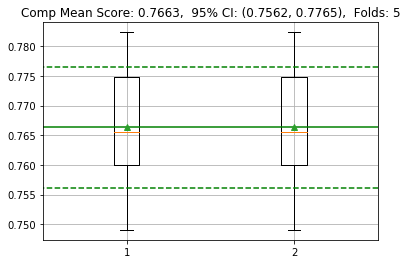

In [78]:
w = []
labels = None
print len(w)
if len(w) == 0:
    w = np.exp((scoreL - np.mean(scoreL))/np.min(np.std(scoreL, axis = 0)))
    w = np.sum(w/np.sum(w), axis = 0)
print w
score = CrossScore(y, [yt2pL], irtL_t, w)
ScorePlot(np.vstack([score, scoreL.T]).T, labels)

In [60]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import hyperopt.pyll.stochastic

def ParColScore(par, fmodel = XGBoost):
    icx = list(wcol.index[wcol.iloc[:,1] > par["a"]])
    x = dac.loc[:, icx]
    x = x.apply(lambda x: x.fillna(x.median()),axis=0)
    x = (x.rank(pct = True)-0.5/x.shape[0]).apply(st.norm.ppf)
    modelL = CrossTrain(x, y, irtL, fmodel)
    yt2pL = CrossValid(x, y, irtL, modelL)
    score = np.mean(CrossScoreAnalysis(y, [yt2pL], irtL)[0])
    return(-score)

# 5-folds
# CrossTrain five models
def ParModelScore(par, fmodel = XGBoost):
    irtL = Kfolds(irt, k = 5)
    modelL = CrossTrain(x, y, irtL, fmodel, parmodel = par)
    yt2pL = CrossValid(x, y, irtL, modelL)
    score = np.mean(CrossScoreAnalysis(y, [yt2pL], irtL)[0])
    return(-score)

def HpOpt(space, fhpscore, seed = 0, max_evals = 50):
    def Obj(par):
        print(pd.DataFrame(par, index = [seed]))
        return({
            'loss': fhpscore(par),
            'status': STATUS_OK,
            'loss_variance': 5e-5
            })
    
    np.random.seed(seed)
    trials = Trials()
    best = fmin(Obj,
        space=space,
        algo=tpe.suggest,
        max_evals=max_evals,
        trials=trials)
    op = pd.concat([pd.DataFrame([sum(list(trials.trials[i]["misc"]["vals"].values()), []) for i in range(len(trials))],
                                 columns = list(trials.trials[0]["misc"]["vals"].keys())),
           pd.DataFrame({"loss": trials.losses()})], axis = 1)
    return(op)

In [69]:
print np.exp(-10)
print np.exp(-1)
space = {'C': hp.loguniform('C', -10, -1)}
print(hyperopt.pyll.stochastic.sample(space))

4.53999297625e-05
0.367879441171
{'C': 0.00010508093979893652}


## Model Training
Cross model and prediction results from optimized model variables and hyper-parameters

In [93]:
def Kfolds(x, k = 10, seed = 1):
    np.random.seed(seed)
    xL = np.array_split(np.random.choice(x, len(x), replace = False), k) #  相当于shuffle
    return(xL)

def GroupSelect(xL, i = 0):
    # xLc = xL.copy()
    # 改写
    xLc = copy.copy(xL)
    ingrp = list(xLc.pop(i))
    exgrp = sum([list(x) for x in xLc], [])
    return(ingrp, exgrp)

def TrainSet(x, y, irtL, ig = 0):
    irt2, irt1 = GroupSelect(irtL, i = ig)
    xt1, xt2 = x.loc[irt1].values, x.loc[irt2].values
    yt1, yt2 = y.loc[irt1].values, y.loc[irt2].values
    return(xt1, xt2, yt1, yt2)

def CrossTrain(x, y, irtL, fmodel, **kwargs):
    modelL = []
    for i in range(len(irtL)):
        xt1, xt2, yt1, yt2 = TrainSet(x, y, irtL, ig = i)
        modelL.append(fmodel(xt1, xt2, yt1, yt2, seed = i, **kwargs))
    return(modelL)

def CrossValid(x, y, irtL, modelL):
    yt2pL = []
    for i in range(len(irtL)):
        xt1, xt2, yt1, yt2 = TrainSet(x, y, irtL, ig = i)
        yt2p = ModelPredict(xt2, modelL[i])
        yt2pL.append(yt2p)
    return(yt2pL)

In [94]:
def ScoreWeight(score):
    w = np.exp((score - np.mean(score))/np.min(np.std(score, axis = 0)))
    w = np.sum(w/np.sum(w), axis = 0)
    return(w)

# ?!
def CrossScore(y, yt2pM, irtL, w = 1):
    score = []
    for i in range(len(irtL)):
        xt1, xt2, yt1, yt2 = TrainSet(y, y, irtL, ig = i)
        yt2L = [yt2pM[j][i] for j in range(len(yt2pM))]
        if(w is 1):
            score.append(list(map(lambda x: Score(yt2, x), yt2L)))
        else:
            score.append(Score(yt2, np.array(yt2L).T * w))
    return(np.array(score))

def CrossScoreAnalysis(y, yt2pM, irtL, w = [], labels = None):
    scoreL = CrossScore(y, yt2pM, irtL)
    if(len(w) == 0):
        w = ScoreWeight(scoreL)
    score = CrossScore(y, yt2pM, irtL, w)
    ScorePlot(np.vstack([score, scoreL.T]).T, labels)
    return(scoreL, score, np.array(w))